Nombre: Marcela Cabrera

# Ejercicio 12: Multimodal Embeddings

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [4]:
%pip install torch torchvision ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install scikit-learn matplotlib pillow


  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.3 MB 6.4 MB/s eta 0:00:01
   --------------------- ------------------ 2.4/4.3 MB 6.6 MB/s eta 0:00:01
   ------------------------------------ --- 3.9/4.3 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/113.8 MB ? eta -:--:--
   ---------------------------------------- 1.0/113.8 MB 2.3 MB/s eta 0:00:49
    --------------------------------------- 1.8/113.8 MB 2.8 MB/s eta 0:00:41
   - -------------------------------------- 2.9/113.8 MB 3.3 MB/s eta 0:00:34
   - -------------------------------------- 3.7/113.8 MB 3.4 MB/s eta 0:00:33
   - -------------------------------------- 4.2/113.8 MB 3.5 MB/s eta 0:00:32
   - -----------------------------

  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


  Cloning https://github.com/openai/CLIP.git to c:\users\hp\appdata\local\temp\pip-req-build-5y508vrf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369632 sha256=39f62a45d61a2330dbea1c44afc9a3acde814a242dc2ab05dd11f3226b1e7473
  Stored in directory: C:\Users\HP\AppData\Local\Temp\pip-ephem-wheel-cache-drppirj7\wheels\cb\a8\74\5f32d6cf0407457f0f62737b6da5c14eb86b9cac476fdf630d
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-5y508vrf'

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [1]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
import urllib.request


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print("Dispositivo:", device)


100%|███████████████████████████████████████| 338M/338M [00:35<00:00, 9.90MiB/s]


Dispositivo: cpu


In [3]:
image_urls = {
    # Perros
    "perro1.jpg": "https://images.unsplash.com/photo-1517849845537-4d257902454a",
    "perro2.jpg": "https://images.unsplash.com/photo-1558788353-f76d92427f16",

    # Gatos
    "gato1.jpg": "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "gato2.jpg": "https://images.unsplash.com/photo-1595433707802-6b2626ef1c91",

    # Autos
    "auto1.jpg": "https://images.unsplash.com/photo-1503376780353-7e6692767b70",
    "auto2.jpg": "https://images.unsplash.com/photo-1549924231-f129b911e442",

    # Aviones
    "avion1.jpg": "https://images.unsplash.com/photo-1529070538774-1843cb3265df",
    "avion2.jpg": "https://images.unsplash.com/photo-1436491865332-7a61a109cc05",

    # Personas
    "persona1.jpg": "https://images.unsplash.com/photo-1500648767791-00dcc994a43e",
    "persona2.jpg": "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",

    # Comida
    "comida1.jpg": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c",
    "comida2.jpg": "https://images.unsplash.com/photo-1504674900247-0877df9cc836",
}

image_paths = []

for name, url in image_urls.items():
    urllib.request.urlretrieve(url + "?w=640", name)
    image_paths.append(name)

len(image_paths)


12

In [4]:
images = [
    preprocess(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
    for p in image_paths
]

with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(img) for img in images])

image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de imágenes:", image_embeddings.shape)


Embeddings de imágenes: torch.Size([12, 512])


In [5]:
texts = [
    "dog",
    "cat",
    "car",
    "airplane",
    "a person with lazy hair and brown",
    "a person white",
    "food"
]

text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de texto:", text_embeddings.shape)


Embeddings de texto: torch.Size([7, 512])


In [6]:
similarity = cosine_similarity(
    text_embeddings.cpu().numpy(),
    image_embeddings.cpu().numpy()
)

similarity


array([[0.28781632, 0.2702706 , 0.21083418, 0.22757694, 0.17812696,
        0.17521866, 0.16639245, 0.17366128, 0.2090187 , 0.18653052,
        0.15814593, 0.14330561],
       [0.22691584, 0.18395472, 0.26137942, 0.27234656, 0.19169259,
        0.17007339, 0.1648421 , 0.17062111, 0.1957867 , 0.2097363 ,
        0.1492318 , 0.13748696],
       [0.21248427, 0.18741316, 0.1800684 , 0.20414937, 0.2517846 ,
        0.1941074 , 0.16198349, 0.17937607, 0.2147305 , 0.21836719,
        0.18578729, 0.1511994 ],
       [0.20103753, 0.17901337, 0.17046921, 0.18623935, 0.17696026,
        0.13973594, 0.15651236, 0.23968281, 0.15846236, 0.2088314 ,
        0.1664199 , 0.13928223],
       [0.22176245, 0.22125319, 0.20708913, 0.21034718, 0.17575093,
        0.18682715, 0.1930665 , 0.16926077, 0.26153386, 0.262574  ,
        0.15005416, 0.15585446],
       [0.22971138, 0.21708512, 0.20161504, 0.2163408 , 0.18725178,
        0.19706346, 0.20940322, 0.19619289, 0.2590667 , 0.24013478,
        0.170736  ,

In [7]:
all_embeddings = torch.cat([image_embeddings, text_embeddings]).cpu().numpy()

pca = PCA(n_components=2, n_oversamples=12)
embeddings_2d_pca = pca.fit_transform(all_embeddings)

img_2d_pca = embeddings_2d_pca[:len(image_embeddings)]
txt_2d_pca = embeddings_2d_pca[len(image_embeddings):]

tsne = TSNE(n_components=2, perplexity=12, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(all_embeddings)

img_2d_tsne = embeddings_2d_tsne[:len(image_embeddings)]
txt_2d_tsne = embeddings_2d_tsne[len(image_embeddings):]

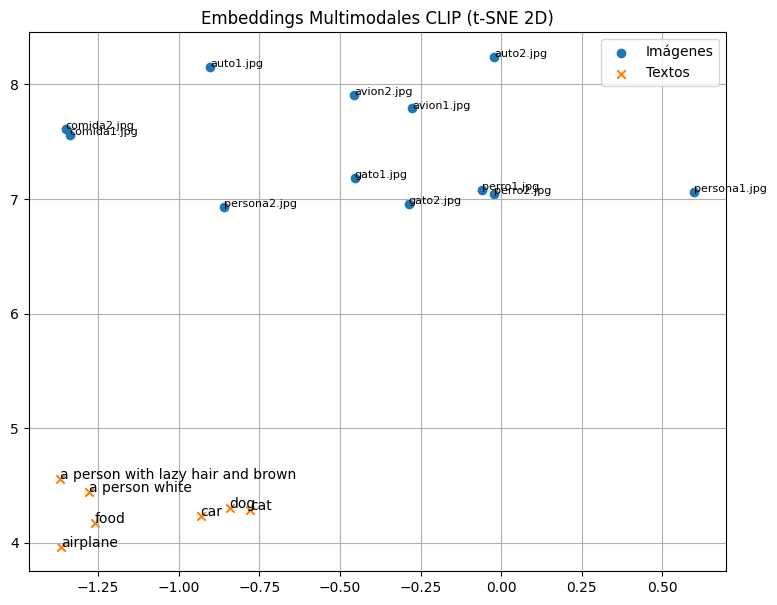

In [8]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_tsne[:,0], img_2d_tsne[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_tsne[i,0], img_2d_tsne[i,1], name, fontsize=8)

plt.scatter(txt_2d_tsne[:,0], txt_2d_tsne[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_tsne[i,0], txt_2d_tsne[i,1], txt, fontsize=10)

plt.title("Embeddings Multimodales CLIP (t-SNE 2D)")
plt.legend()
plt.grid(True)
plt.show()


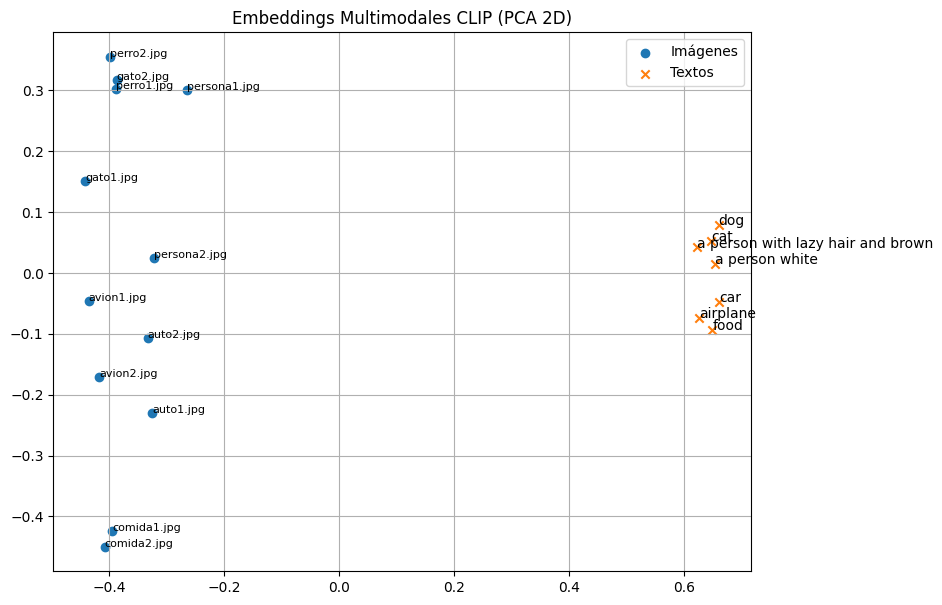

In [9]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_pca[:,0], img_2d_pca[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_pca[i,0], img_2d_pca[i,1], name, fontsize=8)

plt.scatter(txt_2d_pca[:,0], txt_2d_pca[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_pca[i,0], txt_2d_pca[i,1], txt, fontsize=10)

plt.title("Embeddings Multimodales CLIP (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
def buscar_imagen(texto):
    token = clip.tokenize([texto]).to(device)

    with torch.no_grad():
        emb = model.encode_text(token)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        image_embeddings.cpu().numpy()
    )[0]

    idx = np.argmax(scores)

    print("Texto:", texto)
    print("Imagen más similar:", image_paths[idx])
    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off")
    plt.show()


In [11]:
def buscar_texto(nombre_imagen):
    img = preprocess(Image.open(nombre_imagen).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        text_embeddings.cpu().numpy()
    )[0]

    text_scores = zip(texts, scores)
    text_scores = sorted(text_scores, key=lambda x: x[1], reverse=True)
    print(text_scores)

    idx = np.argmax(scores)

    print("Imagen:", nombre_imagen)
    print("Texto más cercano:", texts[idx])
    plt.imshow(Image.open(nombre_imagen))
    plt.axis("off")
    plt.show()


Texto: volar
Imagen más similar: avion2.jpg


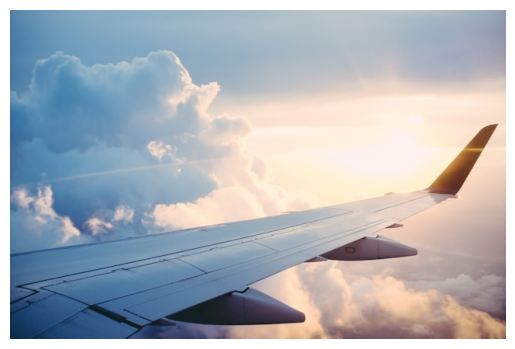

In [13]:
buscar_imagen("volar")